<a href="https://colab.research.google.com/github/Rohini0106-ui/kaggle-brain-mri-classifier/blob/main/fMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow==2.17.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.4/601.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 56.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: ml-dtypes
    Fo

In [ ]:
from google.colab import files
files.upload()  # select the kaggle.json file from your computer
import shutil, os

os.makedirs('/root/.kaggle', exist_ok=True)
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)

print("kaggle.json moved successfully!")


Saving kaggle.json to kaggle.json
kaggle.json moved successfully!


In [ ]:
DATASET_SLUG = 'sartajbhuvaji/brain-tumor-classification-mri'
!kaggle datasets download -d {DATASET_SLUG} -p /content --unzip

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
  0% 0.00/86.8M [00:00<?, ?B/s]
100% 86.8M/86.8M [00:00<00:00, 1.17GB/s]


In [ ]:
import os

# Use the Training folder for creating your dataset
base_path = '/content/Training'

# Check classes
classes = os.listdir(base_path)
print("Classes found:", classes)

for cls in classes:
    cls_path = os.path.join(base_path, cls)
    print(f"{cls}: {len(os.listdir(cls_path))} images")

Classes found: ['no_tumor', 'pituitary_tumor', 'glioma_tumor', 'meningioma_tumor']
no_tumor: 395 images
pituitary_tumor: 827 images
glioma_tumor: 826 images
meningioma_tumor: 822 images


In [ ]:
import cv2
import numpy as np

IMG_SIZE = 224
X = []
y = []

for label_idx, cls in enumerate(classes):
    cls_folder = os.path.join(base_path, cls)
    for fname in os.listdir(cls_folder):
        fpath = os.path.join(cls_folder, fname)
        img = cv2.imread(fpath)  # reads in BGR
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img)
        y.append(label_idx)

X = np.array(X, dtype='float32') / 255.0  # normalize
y = np.array(y)

print("Total images:", X.shape, "Labels:", y.shape)

Total images: (2870, 224, 224, 3) Labels: (2870,)


In [ ]:
#splitting the data
from sklearn.model_selection import train_test_split

# Split: 70% train, 15% validation, 15% test
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)

print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (2009, 224, 224, 3) (2009,)
Validation set: (430, 224, 224, 3) (430,)
Test set: (431, 224, 224, 3) (431,)


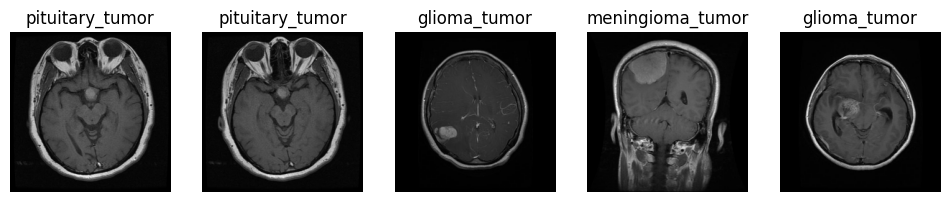

In [ ]:
#optional check few imanges
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB))
    plt.title(classes[y_train[i]])
    plt.axis('off')
plt.show()

In [ ]:
#build and train the CNN
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Number of classes
num_classes = len(classes)

# Build the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze base

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(base_model.input, outputs)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
#training the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=8
)

Epoch 1/5
252/252 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - accuracy: 0.5789 - loss: 1.0421 - val_accuracy: 0.5767 - val_loss: 1.0291
Epoch 2/5
252/252 ━━━━━━━━━━━━━━━━━━━━ 408s 1s/step - accuracy: 0.5755 - loss: 1.0213 - val_accuracy: 0.5930 - val_loss: 1.0459
Epoch 3/5
252/252 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.6019 - loss: 0.9981 - val_accuracy: 0.6279 - val_loss: 0.9868
Epoch 4/5
252/252 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - accuracy: 0.6136 - loss: 0.9861 - val_accuracy: 0.6302 - val_loss: 0.9793
Epoch 5/5
252/252 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - accuracy: 0.5957 - loss: 0.9777 - val_accuracy: 0.6279 - val_loss: 0.9651


In [ ]:
#exaluate the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

14/14 ━━━━━━━━━━━━━━━━━━━━ 70s 5s/step - accuracy: 0.6363 - loss: 0.9323
Test Accuracy: 0.6380510330200195


In [ ]:
#vizualization
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Helper function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


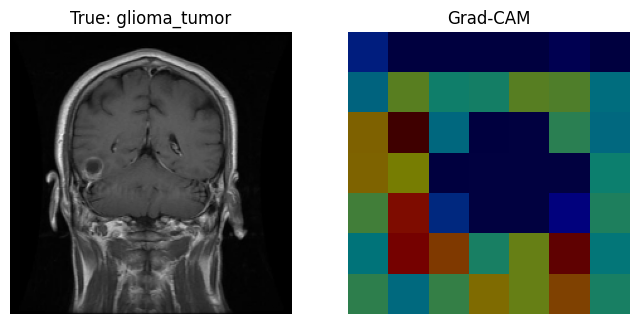

In [ ]:
# Choose a test image index
i = 0
img = X_test[i]
img_input = np.expand_dims(img, axis=0)

# For ResNet50 the last conv layer is usually 'conv5_block3_out'
last_conv_layer_name = 'conv5_block3_out'

# Generate heatmap
heatmap = make_gradcam_heatmap(img_input, model, last_conv_layer_name)

# Overlay heatmap on the original image
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"True: {classes[y_test[i]]}")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title("Grad-CAM")
plt.axis('off')
plt.show()


In [ ]:
#save the nodel
# Save the model locally in Colab
model.save('/content/brain_tumor_model_resnet50.h5')
print("Model saved locally as brain_tumor_model_resnet50.h5")

Model saved locally as brain_tumor_model_resnet50.h5


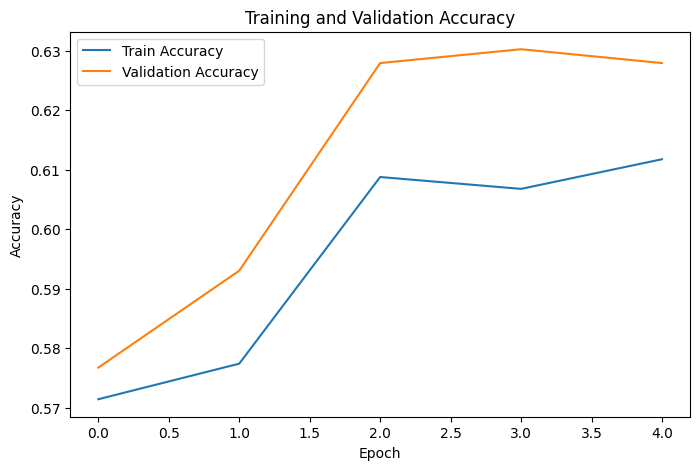

14/14 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step - accuracy: 0.6363 - loss: 0.9323

Test Accuracy: 0.6381
14/14 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step

Classification Report:

                  precision    recall  f1-score   support

        no_tumor       0.77      0.29      0.42        59
 pituitary_tumor       0.64      0.95      0.77       124
    glioma_tumor       0.66      0.68      0.67       124
meningioma_tumor       0.57      0.45      0.50       124

        accuracy                           0.64       431
       macro avg       0.66      0.59      0.59       431
    weighted avg       0.64      0.64      0.62       431


Confusion Matrix:
 [[ 17  12  12  18]
 [  0 118   4   2]
 [  0  17  84  23]
 [  5  36  27  56]]


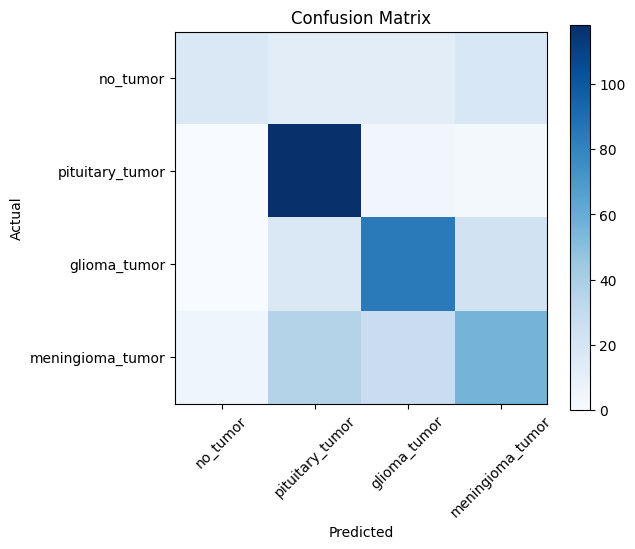

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


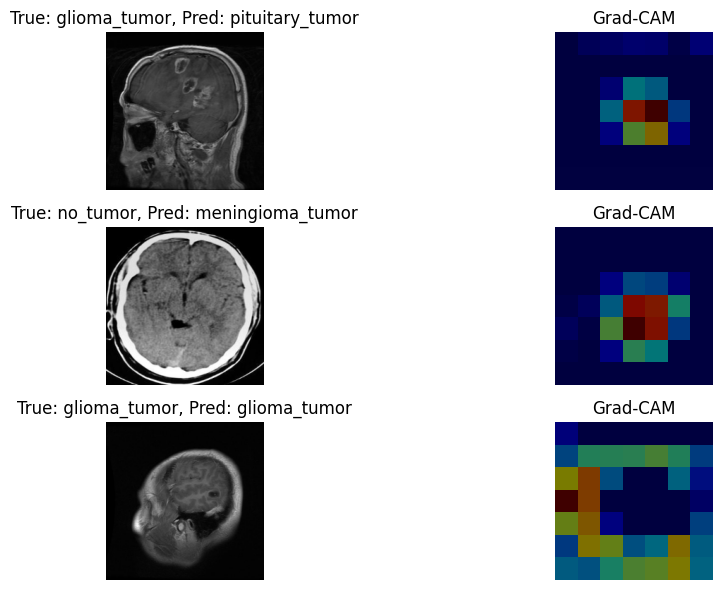

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import cv2

# 1Plot Training & Validation Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 2️Evaluate on Test Set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Classification report
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=45)
plt.yticks(ticks=np.arange(len(classes)), labels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 3️Sample Grad-CAM Visualizations
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# Display Grad-CAM for 3 random test images
import random
last_conv_layer_name = 'conv5_block3_out'

sample_indices = random.sample(range(len(X_test)), 3)
plt.figure(figsize=(12,6))
for i, idx in enumerate(sample_indices):
    img = X_test[idx]
    img_input = np.expand_dims(img, axis=0)
    heatmap = make_gradcam_heatmap(img_input, model, last_conv_layer_name)

    plt.subplot(3,2,i*2+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"True: {classes[y_test[idx]]}, Pred: {classes[y_pred[idx]]}")
    plt.axis('off')

    plt.subplot(3,2,i*2+2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM")
    plt.axis('off')
plt.tight_layout()
plt.show()
